# **The Write-up**
**The goal** of the present project is to create a number of functios that allow getting statistical data on various properties of Chuvash syntax in Chuvash literary texts. Without claiming to be an infallible device for syntactic analysis, the functions are intendent to give an approximate picture of how Chuvash literary texts are built. This project contains **the following functions**: 
+ a function, allowing to buid a small corpus of literary Chuvash texts from this [web-site](https://www.chuvash.org/lib);
+ two functions allowing getting a picture on the word-fomrs in the clause-final position in literary Chuvash;
+ a function allowing making an overview on the use of 3rd personal possessive marker as the marker of definiteness in literary Chuvash.

Turning to details, the **small corpus** function creates a small corpus from the texts found in the list of web-pages in a form of a list of web-pages given as an argument to this function.
The **word_order** and **word_order2** functions provide an overview on the number and percentage of clauses with different types of codas in the texts of the corpus. Chuvas is a Turkic language with the canonical SOV word-order. However, the spoken language appears to allow placing some types of constituents after a verb in a clause. Most typically, the very final position is allowed for pronouns. The goal of this experimant is to check if some of the tendentions of this sort are possible to observe in the modern literary Chuvash text. The predictions is that the characters' speech would be different from the author's speech in this regard. Very briefly, both functions work in the following way:
1. The function checks if a particular text section is a speech of a character or of the author and collects all the sections of the same type in a list.
2. The function counts a number of sentences in the resulting list and the number of one-word sentences.
3. Then it checkes if the final word of a sentecne belongs to one of the following word-form groups: (i) finite verbs, (ii) invinitives, (iii) pronouns, (iv) negative particle, (v) existential particle, (vi) present tense participle (-nƏ form), (vii) simultaneous converb (-sA form), (viii) negative participle or (iv) other types of codas.
4. In the result, function gives a table representig the distribution of different codas in the particular type of text (characters' speech or author's speech)

The **i_func** function allows traking how the third personal possessive marker _-i_ is used as a definiteness marker. In particular, this function does the following:
1. First, the function tokenizes the small corpus and for each word in the resulting list checks if this word ends on _-i_ or not (e.g. is marked with the third person possessive affix);
2. Then the function tests if the found word is in the list of words inherently having the _-i_ ending by adressing externrlly specified dictionary. If the found word is not in the list of inherent _-i_ forms, the function then checks if the preceeding word has the genitive ending, which allows to capture the cases when _-i_ is just a marker of possession.
3. Then the function creates a list of possible unmarked forms of the found word by deleting the last one or two letters of that word and adding one of the Chuvash vowels to the resulting string (_-i_ can only be attached to the vowel-final stems sometimes causeing reduplication of the final consonant). For each of the resulting forms the function checks if that form is present in the list of words obtained as a result of tokenization of the corpus and what index it has. 
4. For each case when the possible forms is found in the corpus, the function creates a dictionary pair, which contains a word marked with _-i_ and the distance (in the number of words) between that word and the first mention of that word without definiteness marker. This allows us to catch all the cases of _-i_ being used as a definiteness marker and to suppose the required discourse distance (Givon 2017) for the use of this marker.

The crucial fact about this function is that it works very long or doesn't work at all.


The **limitations** of the proposed project are very significant. First, the **word_order** and **word_order2** functions **_do not allow to count_**  the exact number of clauses in the text, not the number of sentences, because to do that one should be able to distingush between bifferent the functions of periods in Chuvash texts, which is hardly possible. This is important because we have no acces to the intra-sentence syntax in these circumstances. Second, these functions **_make no difference_** between full-fledged clauses with a verb and extremely short sentences of two words.  The limitations of the **i_func** function are even more fatal because even if it works, it (1) does not allow to track the usage of another allomorph of third person possessive affix -- _-ё_ because _ё_ is a very frequent ending in Chuvash and it is hard to distinguish between marked and unmarked forms. Moreover, it doesn't show how a particular form was used (with or without _-i_ marking) throught the text. For example, it doesn't show if the definiteness marking was lost at some point. And most importantly it doesn't make difference between the referents, just about the words. So, in case there are two dogs in the story, it will not make differece between how the word dog is used in relation to each of the characteds.

# **Three functions**

In [1]:
import re
import requests
from bs4 import BeautifulSoup
from string import punctuation
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import random

### _1. Corpus creation_

In [2]:
def small_corpus(small):
    corpus = ''
    links = small
    for c in links:
        page = requests.get(c)
        soup = BeautifulSoup(page.content, 'html.parser')
        res = soup.find_all(class_="story")[0]
        text = res.get_text()
        corpus = corpus + text
    return corpus

### _2. Word order in characters' speech_

In [3]:
def word_order(s):
    clauses_sum_cs = 0
    num_one_word_clauses_cs = 0
    verb_final_cs = 0
    verb_final_cs_ex = []
    final_words_cs = []
    pronoun_final_cs = 0
    imperatives_and_others_cs = 0
    questions_cs = 0
    converb_final_cs = 0
    participle_final_cs = 0
    neg_participle_final_cs = 0
    neg_particles_final_cs = 0
    exi_final_cs = 0
    infinitives_cs = 0
    others_cs = 0
    others_cs_examples = []
    clauses_sum_au = 0
    num_one_word_clauses_au = 0  
    final_punct = ['.', '!', '?']
    pronouns = ['эпӗ','эпĕ','эп','эсӗ', 'эсĕ', 'эс', 'вӑл', 'вăл','эпир', 'эпӗр', 'эпĕр', 'эсир', 'эсӗр', 'эсĕр', 'вӗсем', 'вĕсем', 'ăна', 'мана', 'сана']
    converbs = ['cа','са','cа','са','cе','се','cе','се']
    participles = ['нӑ','нӑ','нă','нă','нӗ','нӗ','нĕ','нĕ']
    neg_particles = ['çук', 'мар']
    exi = ['пур']
    character_speech = []
    authors_speech = [] 
    corp = small_corpus(s)
    splitted = re.split('\n', corp)
    for s in splitted:
        if re.search('^[—]', s):
            character_speech.append((re.search('^[—].*', s)).group())
    for cs in character_speech:
        sent1 = cs.count(".")
        sent2 = cs.count("!")
        sent3 = cs.count("?")
        clauses = sent1 + sent2 + sent3
        clauses_sum_cs = clauses_sum_cs + clauses
        if len(list(cs.split())) == 2:
            num_one_word_clauses_cs = num_one_word_clauses_cs + 1
        words = cs.split()
        for word in words:
            for symbol in word:
                if symbol in final_punct:
                    final_word_cs = word.strip(punctuation).lower()
                    if re.search('-и$|-ха$', final_word_cs):
                        final_word_cs = final_word_cs.strip('-и')
                        final_word_cs = final_word_cs.strip('-ха')
                    else:
                        pass
                    if re.search('чĕ$|чĕç$|чăç$|ччĕ$|рĕ$|тăп$|тĕп$|тăн$|тĕн$|ать$|ет$|пăр$|пĕр$|ăр$|ĕр$|тăр$|çĕ$|aç$|eç$|ççĕ$|рăм$|рĕм$|тăм$|тĕм$|чăм$|чĕм$|рăн$|рĕн$|тăн$|тĕн$|чăн$|чĕн$|рĕ$|тĕ$|чĕ$|рăмăр$|рĕмĕр$|тăмăр$|тĕмĕр$|чăмăр$|чĕмĕр$|рăр$|рĕр$|тăр$|тĕр$|чăр$|чĕр$|тĕç$|тăç$|чĕч$|рĕç$|рăç$|ттчĕ$|масть$|мест$|маç$|меç$', final_word_cs):
                        verb_final_cs = verb_final_cs + 1
                        verb_final_cs_ex.append(final_word_cs)
                    else:
                        if final_word_cs in pronouns:
                            pronoun_final_cs = pronoun_final_cs + 1
                        else:
                            if final_word_cs in neg_particles:
                                neg_particles_final_cs = neg_particles_final_cs + 1
                            else:
                                if final_word_cs in exi:
                                    exi_final_cs = exi_final_cs + 1
                                else:
                                    if re.search('са$|се$|нă$|нĕ$', final_word_cs):
                                        result = (re.search('са$|са$|се$|се$|нӑ$|нӑ$|нă$|нă$|нӗ$|нӗ$|нĕ$|нĕ$', final_word_cs)).group()
                                        if result in converbs:
                                            converb_final_cs = converb_final_cs + 1
                                        else:
                                            if result in participles:
                                                participle_final_cs = participle_final_cs + 1
                                    else:
                                        if re.search('ма$|ме$|малла$|мелле$', final_word_cs):
                                            result2 = (re.search('ма$|ме$|малла$|мелле$', final_word_cs)).group()
                                            infinitives_cs = infinitives_cs + 1
                                        else:
                                            if re.search('ман$|мен$', final_word_cs):
                                                neg_participle_final_cs = neg_participle_final_cs +1 
                                            else:
                                                others_cs = others_cs + 1
                                                others_cs_examples.append(final_word_cs)
        percent_of_verb_final_in_character_speech = ((verb_final_cs / clauses_sum_cs) * 100)
        percent_of_pronoun_final_in_character_speech = pronoun_final_cs / clauses_sum_cs * 100
        percent_of_other_in_character_speech = (others_cs / clauses_sum_cs) * 100
        percent_of_imperatives_in_character_speech = (imperatives_and_others_cs / clauses_sum_cs) * 100
        percent_of_questions_in_character_speech = (questions_cs / clauses_sum_cs) * 100
        percent_of_converbs_in_character_speech = (converb_final_cs / clauses_sum_cs) * 100
        percent_of_participles_in_character_speech = (participle_final_cs / clauses_sum_cs) * 100
        percent_of_neg_particles_in_character_speech = (neg_particles_final_cs / clauses_sum_cs) * 100
        percent_of_exi_in_character_speech = (exi_final_cs / clauses_sum_cs) * 100
        percent_of_infinitives_in_character_speech = (infinitives_cs / clauses_sum_cs) * 100
        percent_of_neg_particles_in_cs = (neg_particles_final_cs / clauses_sum_cs) * 100
        data_cs = {'Tyfe of the coda': ['finite verb-final', 'infinitive-final', 'pronoun-final', 'negative particle-final', 'existential particle-final', 'conveerb-final (-sA)', 'participle-final (-nƏ)', 'negative participle-final (-mAn)', 'other types of codas'], 'Number': [verb_final_cs, infinitives_cs, pronoun_final_cs, neg_particles_final_cs, exi_final_cs, converb_final_cs, participle_final_cs, neg_participle_final_cs, others_cs], 'Percentage':[percent_of_verb_final_in_character_speech, percent_of_infinitives_in_character_speech, percent_of_pronoun_final_in_character_speech, percent_of_neg_particles_in_character_speech, percent_of_exi_in_character_speech, percent_of_converbs_in_character_speech, percent_of_participles_in_character_speech, percent_of_neg_particles_in_cs, percent_of_other_in_character_speech]}
        df_cs = pd.DataFrame(data_cs)
        inform = 'We first present the information on characters speech.' + '\n' + 'The total number of sentences was:' + str(clauses_sum_cs) + '\n' + 'The number of one-word sentences was:' + str(num_one_word_clauses_cs) + '\n' + 'Examples of the other types of codas are:' + str(others_cs_examples[0:50])
        str_inform = str(inform)
    print(str_inform)
    labels = ['finite verb-final', 'infinitive-final', 'pronoun-final', 'negative particle-final', 'existential particle-final', 'conveerb-final (-sA)', 'participle-final (-nƏ)', 'negative participle-final (-MAN)', 'other types of codas']
    colors = ['darksalmon', 'sienna', 'sandybrown', 'tan', 'darkkhaki', 'darkgoldenrod', 'darkolivegreen', 'palegoldenrod', 'peru']
    plt.figure(figsize=(6, 6))
    df_cs['Percentage'].plot(kind='pie', labels = labels, colors=colors)
    plt.title('Percentage')
    return (df_cs)

We first present the information on characters speech.
The total number of sentences was:2336
The number of one-word sentences was:68
Examples of the other types of codas are:['егоров', 'пĕри', 'мĕн', 'егоров', 'седых', 'кунта', 'квадрат', 'еннерех', 'тăрăх', 'егоров', 'çинчен', 'куçп', 'куçпах', 'мĕн', 'тĕп-тĕрĕс', 'тĕп-тĕрĕс', 'пулĕ', 'тĕп-тĕрĕс', 'аван', 'тĕрĕс', 'тĕрĕс', 'пар', 'фиалк', 'шăп', 'шăпах', 'пар', 'вунулттă', 'енакиев', 'кала', 'ахунбаев', 'ахунбаев', 'эппин', 'комбат', '', '', '', 'çинчен', 'хăçан', 'енакиев', 'минутра', 'ракета', 'парар', 'енакиев', 'юлташ', 'тĕп-тĕрĕс', 'кунта', 'тăрăх', 'наблюдатель', 'тĕп-тĕрĕс', 'ачапа']


,Tyfe of the coda,Number,Percentage
0,finite verb-final,847,36.258562
1,infinitive-final,34,1.455479
2,pronoun-final,104,4.452055
3,negative particle-final,64,2.739726
4,existential particle-final,10,0.428082
5,conveerb-final (-sA),120,5.136986
6,participle-final (-nƏ),106,4.537671
7,negative participle-final (-mAn),17,2.739726
8,other types of codas,1034,44.263699


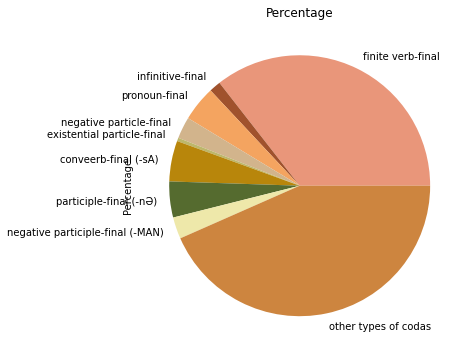

In [4]:
s = ['https://www.chuvash.org/lib/haylav/7393.1.html', 'https://www.chuvash.org/lib/haylav/7393.2.html','https://www.chuvash.org/lib/haylav/7393.3.html','https://www.chuvash.org/lib/haylav/7393.4.html','https://www.chuvash.org/lib/haylav/7393.5.html', 'https://www.chuvash.org/lib/haylav/7393.6.html','https://www.chuvash.org/lib/haylav/7393.7.html','https://www.chuvash.org/lib/haylav/7393.8.html','https://www.chuvash.org/lib/haylav/7393.9.html','https://www.chuvash.org/lib/haylav/7393.10.html','https://www.chuvash.org/lib/haylav/7393.11.html','https://www.chuvash.org/lib/haylav/7393.12.html','https://www.chuvash.org/lib/haylav/7393.13.html','https://www.chuvash.org/lib/haylav/7393.14.html','https://www.chuvash.org/lib/haylav/7393.15.html','https://www.chuvash.org/lib/haylav/7393.16.html']
word_order(s)

### _3. Word order in author's speech_

In [5]:
def word_order2(s):
    clauses_sum_au = 0
    num_one_word_clauses_au = 0
    verb_final_au = 0
    verb_final_au_ex = []
    final_words_au = []
    pronoun_final_au = 0
    imperatives_and_others_au = 0
    questions_au = 0
    converb_final_au = 0
    participle_final_au = 0
    neg_participle_final = 0
    neg_particles_final_au = 0
    exi_final_au = 0
    infinitives_au = 0
    others_au = 0
    others_au_examples = []
    final_punct = ['.', '!', '?']
    pronouns = ['эпӗ','эпĕ','эп','эсӗ', 'эсĕ', 'эс', 'вӑл', 'вăл','эпир', 'эпӗр', 'эпĕр', 'эсир', 'эсӗр', 'эсĕр', 'вӗсем', 'вĕсем', 'ăна', 'мана', 'сана']
    converbs = ['cа','са','cа','са','cе','се','cе','се']
    participles = ['нӑ','нӑ','нă','нă','нӗ','нӗ','нĕ','нĕ']
    neg_particles = ['çук', 'мар']
    exi = ['пур']
    authors_speech = [] 
    corp = small_corpus(s)
    splitted = re.split('\n', corp)
    for s in splitted:    
        if re.search('^[^—123456789]', s):
            res_as = (re.search('^[^—123456789].*', s)).group()
            authors_speech.append(res_as)
    for au in authors_speech:
        sent4 = au.count(".")
        sent5 = au.count("!")
        sent6 = au.count("?")
        clauses_au = sent4 + sent5 + sent6
        clauses_sum_au = clauses_sum_au + clauses_au
        if len(list(au.split())) == 2:
            num_one_word_clauses_au = num_one_word_clauses_au + 1
        words_au = au.split()
        for word_au in words_au:
            for symbol_au in word_au:
                if symbol_au in final_punct:
                    final_word_au = word_au.strip(punctuation).lower()
                    if re.search('-и$|-ха$', final_word_au):
                        final_word_au = final_word_au.strip('-и')
                        final_word_au = final_word_au.strip('-ха')
                    else:
                        pass
                    if re.search('чĕ$|чĕç$|чăç$|ччĕ$|рĕ$|тăп$|тĕп$|тăн$|тĕн$|ать$|ет$|пăр$|пĕр$|ăр$|ĕр$|тăр$|çĕ$|aç$|eç$|ççĕ$|рăм$|рĕм$|тăм$|тĕм$|чăм$|чĕм$|рăн$|рĕн$|тăн$|тĕн$|чăн$|чĕн$|рĕ$|тĕ$|чĕ$|рăмăр$|рĕмĕр$|тăмăр$|тĕмĕр$|чăмăр$|чĕмĕр$|рăр$|рĕр$|тăр$|тĕр$|чăр$|чĕр$|тĕç$|тăç$|чĕч$|рĕç$|рăç$|ттчĕ$|масть$|мест$|маç$|меç$', final_word_au):
                        verb_final_au = verb_final_au + 1
                        verb_final_au_ex.append(final_word_au)
                    else:
                        if final_word_au in pronouns:
                            pronoun_final_au = pronoun_final_au + 1
                        else:
                            if final_word_au in neg_particles:
                                neg_particles_final_au = neg_particles_final_au + 1
                            else:
                                if final_word_au in exi:
                                    exi_final_au = exi_final_au + 1
                                else:
                                    if re.search('са$|се$|нă$|нĕ$', final_word_au):
                                        result = (re.search('са$|са$|се$|се$|нӑ$|нӑ$|нă$|нă$|нӗ$|нӗ$|нĕ$|нĕ$', final_word_au)).group()
                                        if result in converbs:
                                            converb_final_au = converb_final_au + 1
                                        else:
                                            if result in participles:
                                                participle_final_au = participle_final_au + 1
                                    else:
                                        if re.search('ма$|ме$|малла$|мелле$', final_word_au):
                                            infinitives_au = infinitives_au + 1
                                        else:
                                            if re.search('ман$|мен$', final_word_au):
                                                neg_participle_final = neg_participle_final +1 
                                            else:
                                                others_au = others_au + 1
                                                others_au_examples.append(final_word_au)
        percent_of_verb_final_in_au = (verb_final_au / clauses_sum_au) * 100
        percent_of_pronoun_final_in_au = (pronoun_final_au / clauses_sum_au) * 100
        percent_of_other_in_au = (others_au / clauses_sum_au) * 100
        percent_of_imperatives_in_au = (imperatives_and_others_au / clauses_sum_au) * 100
        percent_of_questions_in_au = (questions_au / clauses_sum_au) * 100
        percent_of_converbs_in_au = (converb_final_au / clauses_sum_au) * 100
        percent_of_participles_in_au = (participle_final_au / clauses_sum_au) * 100
        percent_of_neg_particles_in_au = (neg_particles_final_au / clauses_sum_au) * 100
        percent_of_exi_in_au = (exi_final_au / clauses_sum_au) * 100
        percent_of_infinitives_in_au = (infinitives_au / clauses_sum_au) * 100
        percent_of_neg_participle_in_au = (neg_particles_final_au / clauses_sum_au) * 100
        data_au = {'Tyfe of the coda': ['finite verb-final', 'infinitive-final', 'pronoun-final', 'negative particle-final', 'existential particle-final', 'conveerb-final (-sA)', 'participle-final (-nƏ)', 'negative participle-final (-MAN)', 'other types of codas'], 'Number': [verb_final_au, infinitives_au, pronoun_final_au, neg_particles_final_au, exi_final_au, converb_final_au, participle_final_au, neg_participle_final, others_au], 'Percentage':[percent_of_verb_final_in_au, percent_of_infinitives_in_au, percent_of_pronoun_final_in_au, percent_of_neg_particles_in_au, percent_of_exi_in_au, percent_of_converbs_in_au, percent_of_participles_in_au, percent_of_neg_participle_in_au, percent_of_other_in_au]}
        df_au = pd.DataFrame(data_au)
        inform = 'Now, the information on authors speech.' + '\n' + 'The total number of sentences was:' + str(clauses_sum_au) + '\n' + 'The number of one-word sentences was:' + str(num_one_word_clauses_au) + '\n' + 'Examples of other types of codas are:' + str(others_au_examples)
        str_inform = str(inform)
    print(str_inform)
    labels = ['finite verb-final', 'infinitive-final', 'pronoun-final', 'negative particle-final', 'existential particle-final', 'conveerb-final (-sA)', 'participle-final (-nƏ)', 'negative participle-final (-mAn)', 'other types of codas']
    colors = ['darksalmon', 'sienna', 'sandybrown', 'tan', 'darkkhaki', 'darkgoldenrod', 'darkolivegreen', 'palegoldenrod', 'peru']
    plt.figure(figsize=(6, 6))
    df_au['Percentage'].plot(kind='pie', labels = labels, fontsize= 8, colors=colors)
    plt.title('Percentage')
    return (df_au)

Now, the information on authors speech.
The total number of sentences was:2455
The number of one-word sentences was:3
Examples of other types of codas are:['тăна', 'унăн', 'вара', 'тен', 'калăн', 'та', 'сасартăк', 'ку?»', 'ку', 'чавн', 'сас', 'çук»', 'тата', 'тата', 'тата', 'егоров', 'малалла', 'вĕсен', 'ларт', 'каять', 'кирлĕ', 'вăхăт', 'вĕсене', 'мар-ши?»', 'тав', 'разведчиксем', 'çынни', 'унăн', 'вара', 'иккен', 'разведчиксене', 'пулнă-çке', '«а-а-а...»', '«а-а-а...»', '«а-а-а...»', 'ту', 'пĕррех', 'эппин', 'туртас', 'те', '«а-а-а', 'а-а-а!..»', 'а-а-а!..»', 'а-а-а!..»', 'ĕç', 'кулăшла', 'биденко', 'тусăм', 'çине', 'ача', 'çури', 'биденко', 'хушнă»', 'кай', 'иккен', 'иккен', 'чеескер', 'сире', 'пултарать!»', 'унпа»', 'та', '«студебеккер»', 'хаяр', 'курăнать»', 'иккен', 'йĕркеллĕ', 'хăрушă', 'куçĕсем', 'вĕсенче', 'лекни', 'çынсем', 'вăл»', 'çеç', 'кĕçĕнтерех', 'турăçăм', 'вĕт', 'çавсемех', 'шутлĕ', 'пĕрле', 'сирĕншĕн', 'кайăп', 'уншăн', 'пичче!»', 'çинĕ-çке', 'капла', 'вара', 'тавăрă

,Tyfe of the coda,Number,Percentage
0,finite verb-final,885,36.048880
1,infinitive-final,23,0.936864
2,pronoun-final,20,0.814664
3,negative particle-final,18,0.733198
4,existential particle-final,1,0.040733
5,conveerb-final (-sA),9,0.366599
6,participle-final (-nƏ),1143,46.558045
7,negative participle-final (-MAN),177,0.733198
8,other types of codas,179,7.291242


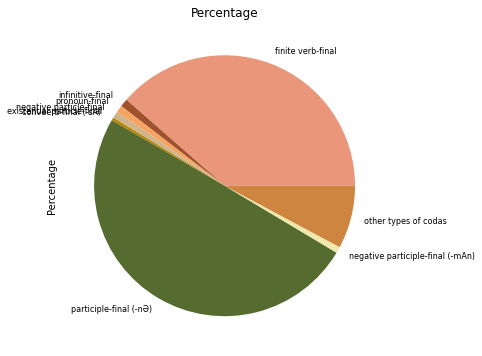

In [6]:
s = ['https://www.chuvash.org/lib/haylav/7393.1.html', 'https://www.chuvash.org/lib/haylav/7393.2.html','https://www.chuvash.org/lib/haylav/7393.3.html','https://www.chuvash.org/lib/haylav/7393.4.html','https://www.chuvash.org/lib/haylav/7393.5.html', 'https://www.chuvash.org/lib/haylav/7393.6.html','https://www.chuvash.org/lib/haylav/7393.7.html','https://www.chuvash.org/lib/haylav/7393.8.html','https://www.chuvash.org/lib/haylav/7393.9.html','https://www.chuvash.org/lib/haylav/7393.10.html','https://www.chuvash.org/lib/haylav/7393.11.html','https://www.chuvash.org/lib/haylav/7393.12.html','https://www.chuvash.org/lib/haylav/7393.13.html','https://www.chuvash.org/lib/haylav/7393.14.html','https://www.chuvash.org/lib/haylav/7393.15.html','https://www.chuvash.org/lib/haylav/7393.16.html']
word_order2(s)

In [1]:
def i_func (s):
    vocab = open('vocab.txt', 'r', encoding='utf-8')
    vocab2 = vocab.read().lower()
    inherent = tokenize(vocab2)
    possible_lexemes = []
    marked_words = {}
    marked_words_and_distances = {}
    all_text = ''
    corp = small_corpus(s)
    splitted = re.split('\n', corp)
    for s in splitted:
        all_text = all_text + s
    tokenized = tokenize (all_text)
    joined = ' '.join(tokenized)
    number_of_words = len(tokenized)
    for nw in range(number_of_words):
        if re.search('и$', tokenized[nw]):
            if tokenized[nw] in inherent:
                pass
            else:
                preceeding = tokenized[nw-1]
                if re.search('ăн$|ĕн$', preceeding):
                    pass
                else:
                    lex = (tokenized[nw])[:-1]
                    lex1 = lex + 'а'
                    lex2 = lex + 'ă'
                    lex3 = lex + 'e'
                    lex4 = lex + 'ĕ'
                    lex5 = lex + 'у'
                    lex6 = lex + 'ы'
                    lex7 = lex + 'ӳ'
                    lexeme = (tokenized[nw])[:-2]
                    lexeme1 = lexeme + 'а'
                    lexeme2 = lexeme + 'ă'
                    lexeme3 = lexeme + 'e'
                    lexeme4 = lexeme + 'ĕ'
                    lexeme5 = lexeme + 'у'
                    lexeme6 = lexeme + 'ы'
                    lexeme7 = lexeme + 'ӳ'
                    possible_lexemes.append(lex1)
                    possible_lexemes.append(lex2)
                    possible_lexemes.append(lex3)
                    possible_lexemes.append(lex4)
                    possible_lexemes.append(lex5)
                    possible_lexemes.append(lex6)
                    possible_lexemes.append(lex7)
                    possible_lexemes.append(lex)
                    possible_lexemes.append(lexeme1)
                    possible_lexemes.append(lexeme2)
                    possible_lexemes.append(lexeme3)
                    possible_lexemes.append(lexeme4)
                    possible_lexemes.append(lexeme5)
                    possible_lexemes.append(lexeme6)
                    possible_lexemes.append(lexeme7)                    
                    for l in possible_lexemes:
                        try:
                            position = tokenized.index(l)
                        except ValueError:
                            pass
                        else:
                            distance = nw - position
                            marked_words_and_distances[tokenized[nw]] = distance                            
    return (print(marked_words_and_distances))